# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)







### Загрузка данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Легенда:
   

**Признаки:**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак:**

* Price — цена (евро)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df[df.duplicated(keep=False)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Выделим  важные признаки**

VehicleType, Gearbox, Power, Kilometer, FuelType, Brand, NotRepaired, RegistrationYear, Model.

Признаки NumberOfPictures, DateCreated, PostalCode, DateCrawled, RegistrationMonth, LastSeen не несут полезной информации, их можно удалить.




### Предобработка данных


Проверим целевой признак **price** на нулевые значения:


In [7]:
print("Колличество объявлений с нулевой ценой:",len(df.loc[df['Price'] == 0]))

Колличество объявлений с нулевой ценой: 10772


In [8]:
df = df.loc[df['Price'] != 0]


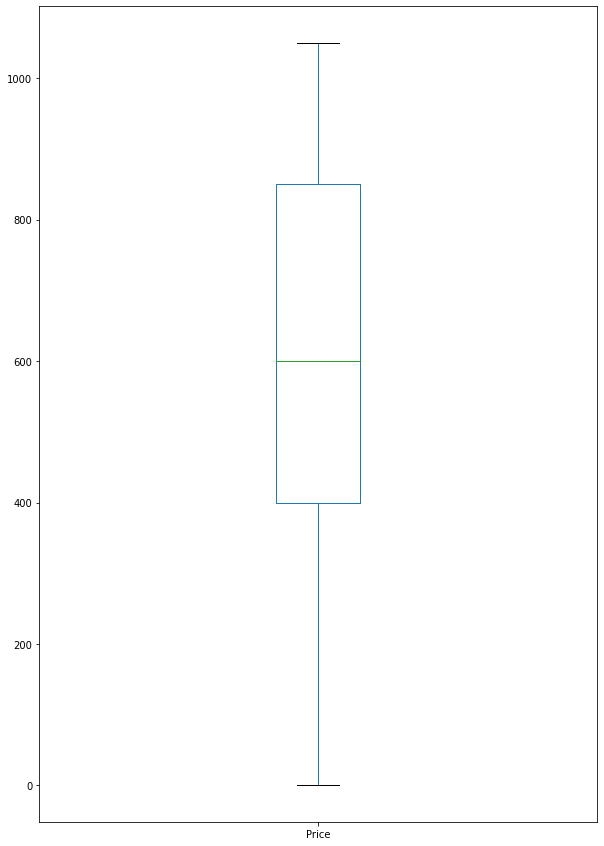

Колличество объявлений с ценой меньше 300 долларов: 12391


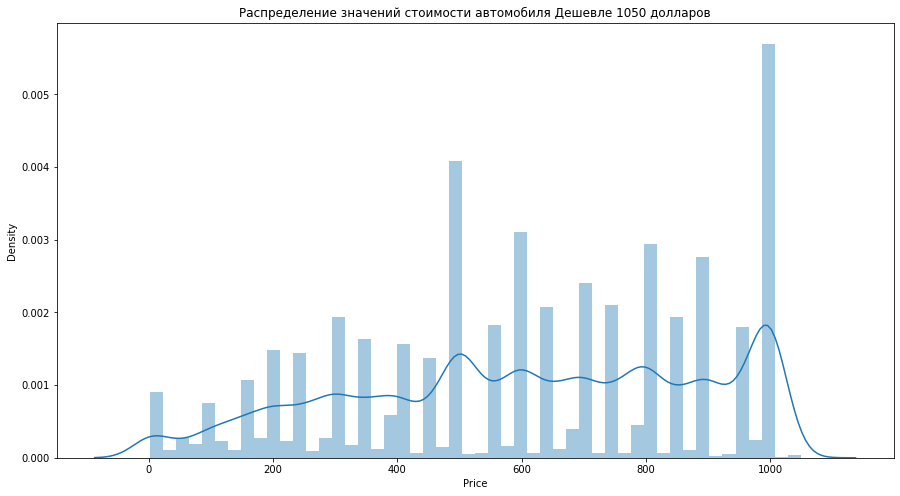

In [9]:
df_clear=df.loc[(df['Price']<1050)]
df_clear["Price"].plot(kind = 'box', figsize = (10, 15), label ='Price')
plt.show()


plt.figure(figsize=(15,8))
sns.distplot(df_clear["Price"])
plt.title('Распределение значений стоимости автомобиля Дешевле 1050 долларов', fontsize=12)

print("Колличество объявлений с ценой меньше 300 долларов:",len(df_clear.loc[df['Price'] < 300]))


На графике видны всплески в районе круглых значений, что свойственно людям, а также круглое значение + ~20 долларов, которые затем обычно сбрасывают при торге, продавая, в итоге, за круглые значения. Таким образом, в большинстве своем, скорее всего это не аномалии. Однако, согласно современным данным <a href="https://www.ooyyo.com/united+states/used-cars-for-sale/c=CDA31D7114D3854F111BF66FAA652D53EDA2/">американского сайта с 1 317 971 объявлением о продаже б\у автомобилей</a> автомобили дешевле 400$ - редкость. Но поскольку у нас менее свежая база - проведем границу в районе 300 долларов.


In [10]:
df = df.loc[df['Price']> 299]

Заодно проверим на дубликаты:

In [11]:
df.duplicated().sum()

4

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()


0

* В **VehicleType** пропусков около 10 процентов, это слишком много чтобы просто их удалить. 
* Замена на среднюю тоже не годиться, т.к. существенно скажется на точности предсказания.
* Заменим пропущенные значения на unknown
<br><br>
* Справка: A vehicle (from Latin: vehiculum) is a machine that transports people or cargo. Vehicles include wagons, bicycles, motor vehicles (motorcycles, cars, trucks, buses, mobility scooters for disabled people), railed vehicles (trains, trams), watercraft (ships, boats, underwater vehicles), amphibious vehicles (screw-propelled vehicles, hovercraft), aircraft (airplanes, helicopters, aerostats) and spacecraft.


In [13]:
print("Колличество объявлений с незаполненным типом кузова:", len(df.loc[df['VehicleType'].isna()]))


Колличество объявлений с незаполненным типом кузова: 29935


In [14]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')


Количество явно некорректных данных **RegistrationYear** незначительно. Удалим.

In [15]:
print("Колличество объявлений с некорректной датой:",len(df.loc[(df['RegistrationYear'] > 2022) | (df['RegistrationYear'] < 1900)]))


Колличество объявлений с некорректной датой: 97


In [16]:
df = df.loc[(df['RegistrationYear'] <= 2022) & (df['RegistrationYear'] >= 1900)]



In [17]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCreated'] = pd.DatetimeIndex(df['DateCreated']).year

In [18]:
df.loc[df['RegistrationYear'] > df['DateCreated']].head()
                  

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,unknown,2018,manual,90,meriva,150000,5,petrol,opel,no,2016,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,2016,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,unknown,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,unknown,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,unknown,2018,manual,64,other,125000,3,NaN,seat,no,2016,0,33397,2016-03-25 10:17:37


In [19]:
print("Количество объявлений с датой регистрации автомобиля более поздней, чем дата объявления :", len(df.loc[df['RegistrationYear'] > df['DateCreated']]), " - Удалим их." )

Количество объявлений с датой регистрации автомобиля более поздней, чем дата объявления : 13427  - Удалим их.


In [20]:
df = df.loc[df['RegistrationYear'] < df['DateCreated']]


Имеются пропуски в **Model**. Удалим их.

In [21]:
print("Колличество объявлений с пропущенной моделью:", len(df.loc[df['Model'].isna()]))


Колличество объявлений с пропущенной моделью: 13064


In [22]:
df = df.loc[~df['Model'].isna()]

Большое колличество пропусков в **Gearbox**. Заменим на наиболее встречающийся тип коробки.

In [23]:
print("Колличество объявлений с незаполненным типом коробки:", len(df.loc[df['Gearbox'].isna()]))


Колличество объявлений с незаполненным типом коробки: 10166


In [24]:
df["Gearbox"] = df["Gearbox"].fillna(df["Gearbox"].mode().values[0])

Имеются значения **Power** равные 0 и больше 1000, что являеться некорректным. Заменим их на медиану по модели.

In [25]:
print("Колличество объявлений с некорректной мощностью:", len(df.loc[(df['Power'] > 1000) | (df['Power'] <= 0)]))


Колличество объявлений с некорректной мощностью: 23368


In [26]:
df.loc[(df['Power'] > 1000) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

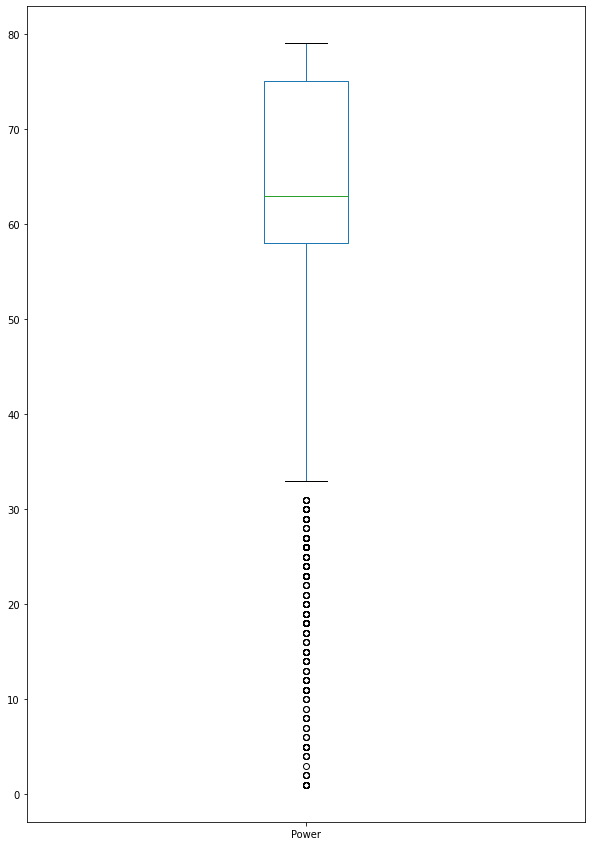

Колличество объявлений с мощностью меньше 80 лошадинных сил: 72061
Колличество объявлений с мощностью меньше 35 лошадинных сил: 856


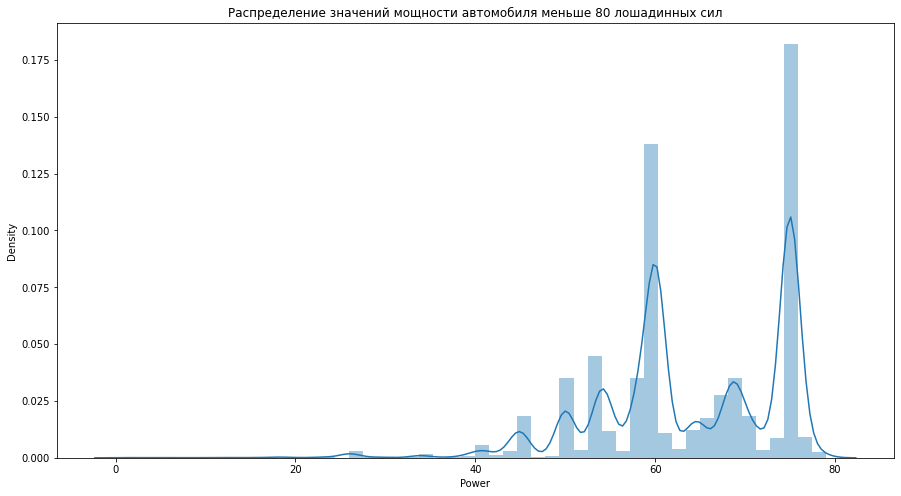

In [27]:
df_clear=df.loc[(df['Power']<80)]
df_clear["Power"].plot(kind = 'box', figsize = (10, 15), label ='Power')
plt.show()


plt.figure(figsize=(15,8))
sns.distplot(df_clear["Power"])
plt.title('Распределение значений мощности автомобиля меньше 80 лошадинных сил', fontsize=12)

print("Колличество объявлений с мощностью меньше 80 лошадинных сил:", len(df_clear.loc[df['Power'] < 80]))
print("Колличество объявлений с мощностью меньше 35 лошадинных сил:", len(df_clear.loc[df['Power'] < 35]))


По ящику с усами видим выборосы на значениях **Power** ниже 35.  Заменим их на медиану по модели.

In [28]:
df.loc[df['Power'] < 35] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')




Пропуски в **FuelType** заменим на наиболее распротраненный тип по моделям.

In [29]:
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))


* Большие пропуски в **Repaired**. 
* Скорее всего, если автомобиль не ремонтировался - этот параметр просто не заполнялся. 
* Заменим пропуски на no, как значение по умолчанию.

In [30]:
df["Repaired"].fillna("no", inplace=True)

Удалим ненужные признаки **NumberOfPictures**, **DateCreated**, **PostalCode**, **DateCrawled**, **RegistrationMonth**, **LastSeen**:

In [31]:
df = df.drop(['NumberOfPictures', 'DateCreated', 'PostalCode', 'DateCrawled', 'RegistrationMonth', 'LastSeen'], axis=1)
df = df.reset_index(drop=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295741 entries, 0 to 295740
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             295741 non-null  float64
 1   VehicleType       295741 non-null  object 
 2   RegistrationYear  295741 non-null  float64
 3   Gearbox           295741 non-null  object 
 4   Power             295741 non-null  int64  
 5   Model             295741 non-null  object 
 6   Kilometer         295741 non-null  float64
 7   FuelType          295741 non-null  object 
 8   Brand             295741 non-null  object 
 9   Repaired          295741 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 22.6+ MB


In [33]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,295741.000000,295741.000000,295741.000000,295741.000000
mean,4886.089474,2002.631515,121.560396,128383.856144
std,4573.130967,6.183588,53.162446,36673.660682
min,300.000000,1910.000000,35.000000,5000.000000
25%,1400.000000,1999.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,115.000000,150000.000000
75%,6990.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2015.000000,1000.000000,150000.000000


## Обучение моделей

### Разделим данные на выборки



In [34]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

df_light = df.copy()
df_light = df_light.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "Repaired":'category'})


In [ ]:
#КОД РЕВЬЮЕРА

cat = list(features_train.select_dtypes('object').columns) #категориальные признаки
num = list(features_train.select_dtypes(exclude='object').columns) #количественные признаки

#МАСШТАБИРУЕМ

scaler = StandardScaler()
features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train[num]), columns=[num], index=features_train.index)
features_test_scaled = pd.DataFrame(scaler.transform(features_test[num]), columns=[num], index=features_test.index)

#обрати внимание, что в features_train_scaled и features_test_scaled отсутствую категориальные признаки 

#КОДИРОВАНИЕ OHE

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

features_train_ohe = enc.fit_transform(features_train[cat]) #а тут нет количественных признаков, только категориальные
features_test_ohe = enc.transform(features_test[cat]) #аналогично

#ОБЪЕДИНЯЕМ МАСШТАБИРОВАННЫЕ КОЛИЧЕСТВЕННЫЕ И КАТЕГОРИАЛЬНЫЕ ЗАКОДИРОВАННЫЕ ПРИЗНАКИ В ЕДИНУЮ ВЫБОРКУ

features_train_lr = pd.concat([features_train_scaled, pd.DataFrame(features_train_ohe.toarray(), index=features_train.index)], axis=1)
features_test_lr = pd.concat([features_test_scaled, pd.DataFrame(features_test_ohe.toarray(), index=features_test.index)], axis=1)

features_train_lr.head(3)

#ВЫБОРКИ ГОТОВЫ К РАБОТЕ (В ТВОЕМ СЛУЧАЕ ЭТО НАДО КОРРЕКТИРОВАТЬ, ЧТОБЫ ЕЩЕ VALID ВЫБОРКУ ТАКЖЕ ИЗМЕНИТЬ, добавятся 3 строчки)

Разделим данные на выборки

In [35]:
trainX,testX,trainY,testY = train_test_split(df_ohe.drop("Price",axis = 1),
                                             df_ohe["Price"],
                                             test_size = 0.25,
                                             random_state = 42)

trainX_wo_ohe,testX_wo_ohe,trainY_wo_ohe,testY_wo_ohe = train_test_split(df.drop("Price",axis = 1),
                                             df["Price"],
                                             test_size = 0.25,
                                             random_state = 42)
(trainX_wo_ohe_light,
 testX_wo_ohe_light,
 trainY_wo_ohe_light,
 testY_wo_ohe_light) = train_test_split(df_light.drop("Price",axis = 1),
                                             df_light["Price"],
                                             test_size = 0.25,
                                             random_state = 42)


### Обучение моделей

#### Catboost

In [39]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE', random_seed=42)
parameters_cat = {'depth':[10], 'learning_rate':np.arange(0.1, 0.8)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(trainX_wo_ohe, trainY_wo_ohe, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","Repaired"]),
            cv=3,
            partition_random_seed=42,                             
            verbose=True,
            plot=False)

Audio(wave, rate=10000, autoplay=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 6113.5019364	test: 6111.6954466	best: 6111.6954466 (0)	total: 380ms	remaining: 6m 19s
1:	learn: 5596.5350689	test: 5594.4796964	best: 5594.4796964 (1)	total: 767ms	remaining: 6m 22s
2:	learn: 5140.7398545	test: 5139.1207480	best: 5139.1207480 (2)	total: 1.18s	remaining: 6m 31s
3:	learn: 4734.1131162	test: 4733.3952886	best: 4733.3952886 (3)	total: 1.45s	remaining: 6m 1s
4:	learn: 4364.9169155	test: 4366.5046007	best: 4366.5046007 (4)	total: 1.75s	remaining: 5m 48s
5:	learn: 4040.2779058	test: 4043.7861513	best: 4043.7861513 (5)	total: 2.11s	remaining: 5m 49s
6:	learn: 3753.6962144	test: 3758.5144810	best: 3758.5144810 (6)	total: 2.37s	remaining: 5m 36s
7:	learn: 3501.7711421	test: 3508.0581420	best: 3508.0581420 (7)	total: 2.64s	remaining: 5m 27s
8:	learn: 3277.3933221	test: 3283.8794226	best: 3283.8794226 (8)	total: 2.93s	remaining: 5m 23s
9:	learn: 3075.3488012	test: 3082.4083792	best: 3082.4083792 (9)	total: 3.25s	remaining: 5m 21s
10:	learn: 2897.0123139	test: 2903.815000

In [40]:
catboost_grid["params"]
# {'depth': 10, 'learning_rate': 0.1}

{'depth': 10, 'learning_rate': 0.1}

In [41]:
results = pd.DataFrame(catboost_grid['cv_results'])
results.sort_values(by='test-RMSE-mean', ascending=True)[0:1]
#rmse = np.min(results['test-RMSE-mean'])

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,1534.973538,5.548693,1284.429503,0.676068


Проверим время обучения с найденными параметрами для каждой модели

In [42]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(trainX_wo_ohe,trainY_wo_ohe,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]))

Audio(wave, rate=10000, autoplay=True)


0:	learn: 4239.2854701	total: 389ms	remaining: 6m 28s
100:	learn: 1587.2148899	total: 32s	remaining: 4m 45s
200:	learn: 1513.5185161	total: 1m 2s	remaining: 4m 8s
300:	learn: 1466.4412847	total: 1m 36s	remaining: 3m 43s
400:	learn: 1433.5689022	total: 2m 10s	remaining: 3m 14s
500:	learn: 1404.7981559	total: 2m 44s	remaining: 2m 43s
600:	learn: 1385.1619073	total: 3m 19s	remaining: 2m 12s
700:	learn: 1364.4367890	total: 3m 52s	remaining: 1m 39s
800:	learn: 1348.2594814	total: 4m 28s	remaining: 1m 6s
900:	learn: 1333.4693610	total: 5m 2s	remaining: 33.2s
999:	learn: 1319.1545371	total: 5m 37s	remaining: 0us
CPU times: user 5min 37s, sys: 1.59 s, total: 5min 39s
Wall time: 5min 40s


#### RandomForest

In [44]:
%%time

#авоматизизированный перебор параметров для проверки результата с помощью GridSearchCV


model_RandForest_t = RandomForestRegressor(random_state = 42)

#Параметры для GridSearch
parametrs_grid = {'n_estimators': [49, 50],'max_depth' : [49, 50]}

grid_cv = GridSearchCV(model_RandForest_t, parametrs_grid)

grid_cv.fit(trainX, trainY)

Audio(wave, rate=10000, autoplay=True)

CPU times: user 57min 13s, sys: 19.7 s, total: 57min 33s
Wall time: 57min 35s


In [45]:
grid_cv.best_params_
#{'max_depth': 50, 'n_estimators': 50}

#grid_cv.best_score_
#0.8816496602808144

{'max_depth': 50, 'n_estimators': 50}

In [46]:
results = pd.DataFrame(grid_cv.cv_results_)
display(results)
display(results[results['rank_test_score'] == 1])
fit_time = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score'] == 1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time:{predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,160.486678,4.158870,1.126061,0.045127,49,49,"{'max_depth': 49, 'n_estimators': 49}",0.885880,0.883097,0.878260,0.880034,0.880741,0.881602,0.002642,4
1,159.738715,3.330507,1.152224,0.017295,49,50,"{'max_depth': 49, 'n_estimators': 50}",0.885925,0.883074,0.878303,0.880056,0.880675,0.881606,0.002645,3
2,165.099127,3.498152,1.188185,0.036536,50,49,"{'max_depth': 50, 'n_estimators': 49}",0.885764,0.883079,0.878364,0.880153,0.880841,0.881640,0.002556,2
3,159.652383,2.028951,1.147343,0.016121,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.885819,0.883089,0.878390,0.880187,0.880763,0.881650,0.002569,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,159.652383,2.028951,1.147343,0.016121,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.885819,0.883089,0.87839,0.880187,0.880763,0.88165,0.002569,1


Fit time: 159.6523832321167, predict time:1.147342824935913


#### LightGBM 

In [48]:
%%time

#Параметры для GridSearch
param_grid = {'max_depth':[10],
              'learning_rate': [0.1],
              }

model_lightgbm = lgb.LGBMRegressor(random_state = 42)
                                  

lgb_grid_cv = GridSearchCV(model_lightgbm,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               verbose=10,\
                               cv=3)

lgb_grid_cv.fit(trainX_wo_ohe_light, trainY_wo_ohe_light)

print('best params\n', lgb_grid_cv.best_params_)
#best params {'learning_rate': 0.1, 'max_depth': 10}

# parametrs_grid = {'n_estimators': np.arange(37, 45),
#                   'max_depth' : np.arange(2, 10), 
#                   'learning_rate' : [0.1, 0.8]}


Audio(wave, rate=10000, autoplay=True)



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START learning_rate=0.1, max_depth=10.............................
[CV 1/3; 1/1] END ...........learning_rate=0.1, max_depth=10; total time=   7.4s
[CV 2/3; 1/1] START learning_rate=0.1, max_depth=10.............................
[CV 2/3; 1/1] END ...........learning_rate=0.1, max_depth=10; total time=   4.7s
[CV 3/3; 1/1] START learning_rate=0.1, max_depth=10.............................
[CV 3/3; 1/1] END ...........learning_rate=0.1, max_depth=10; total time=   4.5s
best params
 {'learning_rate': 0.1, 'max_depth': 10}
CPU times: user 21.1 s, sys: 144 ms, total: 21.2 s
Wall time: 21.4 s


In [69]:
results = pd.DataFrame(lgb_grid_cv.cv_results_)
display(results)
display(results[results['rank_test_score'] == 1])
fit_time = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score'] == 1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time:{predict_time}')

lgb_grid_cv.best_score_
# 0.8782647915720463

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.781945,1.264471,0.742129,0.040491,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.88091,0.874954,0.878931,0.878265,0.002476,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.781945,1.264471,0.742129,0.040491,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.88091,0.874954,0.878931,0.878265,0.002476,1


Fit time: 4.78194530804952, predict time:0.742129405339559


0.8782647915720463

In [78]:
score = {'Модель':['Random Forest', 'LGBM'], 'Fit time':[159.65, 4.78], 
        'Predict time':[1.14, 0.742], 'Best score':[0.881,  0.878]} 

df_score = pd.DataFrame(score) 
print('Лучшую из этих двух моделей савним с catboost:')
display(df_score)

#{'learn': {'RMSE': 1319.1545370670383}}
#1319.15, 337 секунд

Лучшую из этих двух моделей савним с catboost:


,Модель,Fit time,Predict time,Best score
0,Random Forest,159.65,1.140,0.881
1,LGBM,4.78,0.742,0.878


Посчитаем ошибку  и определим время предсказаний

In [79]:

%%time
print("CatBoost:",mean_squared_error(testY,final_cat.predict(testX_wo_ohe),squared=False))



CatBoost: 1507.072082556892
CPU times: user 1.16 s, sys: 7.98 ms, total: 1.17 s
Wall time: 1.16 s


In [80]:
%%time
print("LightGBM:",(mean_squared_error(testY,lgb_grid_cv.predict(testX_wo_ohe_light),squared=False)))



LightGBM: 1583.4523899866479
CPU times: user 783 ms, sys: 7.68 ms, total: 790 ms
Wall time: 742 ms


## Анализ моделей

Исходя из полученных результатов можно сделать вывод, что: 
* CatBoost: среднеквадратичная ошибка - 1319.15, на тренировку данной модели ушло 5min 37
* Случайный лес: тренеруется очень долго, fit time в 159.65, что в ~ 30 раз выше, чем у LightGBM 4.78, при этом метрика best_score - 0.881, что чуть лучше, чем у LightGBG - 0.878, в силу чего RMSE у случайного леса - 1539.61.
* LightGBM: RMSE - 1583.45, на тренировку ушло 21.1s c. 
<br><br>

* RMSE моделей CatBoost и LightGBM почти совпадают, но CatBoost тренировался быстрее всех.(если смотреть без времени затраченного на подбор оптимальных параметров для CatBoost)
<br><br>

Согласно поставленным условиям, решающим факторами при выборе модели являются следующие показатели:

* Время обучения
* Время предсказания
* Качество предсказаний
<br><br>
Таким образом, если для наших задач важнее всего время - наш выбор - LightGMB, она обходит CatBoost по двум критериям из трех.
Однако, если нужна точность - лучше заряжать CatBoost. 
<br><br>

* **И победителем объявляется: LightGMB!**